## Employee Attrition: Will my employee leave?

### How can we identify at-risk employees for voluntary resignation based on their performance, job satisfaction, and salary, etc., which contributes to attrition?
**Context**
It's estimated that losing an employee can cost a company 1.5-2x the employee’s salary. Depending on the individual’s level of seniority, the financial burden fluctuates. For hourly workers, it costs an average of $1,500 per employee. For technical positions, the cost jumps to 100-150% of salary. At the high end, C-suite turnover can cost up to 213% of the employee’s salary.

Not only are you forced to dedicate time and resources to recruiting, onboarding and training a new hire after an employee leaves, but it’s estimated that two thirds of all sunk costs due to turnover are intangible, including lost productivity and knowledge, and internal strain on employees while the roles remain unfilled. 

Being able to predict, and possibly prevent, employee turnover by identifying employees that may be at-risk for leaving, the cost of replacement hire due to turnover can be minimized and employee retention can increase.

**What contributing factors increase the likelihood of an employee leaving voluntarily?**

### Imports

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import json

**Dataset**

In [5]:
# Dataset 
workers = pd.read_csv("../data/raw/factory_workers.csv", sep=',', encoding="mac_roman")

In [6]:
workers.head()

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
0,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
1,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Efficacy,None,1.489,Efficacy,None,1.2,None,None
2,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
3,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Efficacy,None,1.023,Efficacy,None,0.8,None,None
4,98000003,Elizabeth,Martinez,20,F,Shift 1,Team 3,Team Leader,"[98000001, 98000002, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None


In [7]:
workers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411948 entries, 0 to 411947
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sub_ID                   411948 non-null  int64  
 1   sub_fname                411948 non-null  object 
 2   sub_lname                411948 non-null  object 
 3   sub_age                  411948 non-null  int64  
 4   sub_sex                  411948 non-null  object 
 5   sub_shift                411948 non-null  object 
 6   sub_team                 411948 non-null  object 
 7   sub_role                 411948 non-null  object 
 8   sub_coll_IDs             411948 non-null  object 
 9   sub_colls_same_sex_prtn  411948 non-null  object 
 10  sub_health_h             411948 non-null  float64
 11  sub_commitment_h         411948 non-null  float64
 12  sub_perceptiveness_h     411948 non-null  float64
 13  sub_dexterity_h          411948 non-null  float64
 14  sub_

### **Graphical Exploratory Data Analysis**

Why are the hidden values for supervisors of type object, while the workers' are of type float?

In [65]:
# workers.sup_commitment_h.unique()

In [66]:
# workers.sub_commitment_h.unique()

In [39]:
# Get Column description function
with open("../data/raw/metadata.json") as file:
    column_descriptions = json.load(file)

# Define a lookup function for getting the description of a column name
def get_column_desc(col_name, info=column_descriptions):
    """
    Provides a lookup function for a description of the column name. 
    
    Use if interested in the description of a particular column name, and what type of field it is. 
    
    Parameters:
    col_name(str): The column name you wish to lookup
    info(dict): A dictionary containing the information
    
    Returns: 
    dict: Returns column name, its type of field and its description.
    
    """
    return info[col_name]["Description"]


What were the different recorded 'events'?

In [37]:
get_column_desc('record_comptype')

'A string describing the type of record made by the subject’s supervisor in the factory’s HRM/ERP system, in connection with the underlying behavior performed by the worker; it’s the record component of the event. Possible values are “Presence”, “Absence”, “Resignation”, “Termination”, “Onboarding”, “Efficacy”, “Idea”, “Lapse”, “Feat”, “Slip”, “Teamwork”, “Disruption”, “Sacrifice”, and “Sabotage”. It’s also possible for a supervisor to have overlooked a given qualitative behavior (e.g., a Feat or Teamwork) and thus to have made no record in the HRM/ERP system; in that case, this field’s value will be “None”.'

In [35]:
events = workers['record_comptype'].unique()
events

array(['Presence', 'Efficacy', 'Feat', 'Slip', 'Sacrifice', 'Lapse',
       'Idea', 'Teamwork', 'Absence', 'Disruption', 'None', 'Resignation',
       'Termination', 'Onboarding', 'Sabotage'], dtype=object)

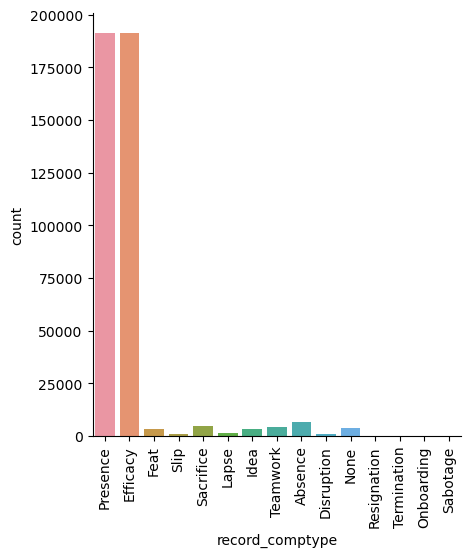

In [36]:
sns.catplot(x='record_comptype', data=workers, kind='count')
plt.xticks(rotation=90)
plt.show()

What are the proportion of events that contributed to employee turnover?

In [50]:
# Retrieve the records that were a result of Resignation or Termination (contributed to turnover)
turnover_events = ['Termination', 'Resignation']
turnover_records = workers[workers['record_comptype'].isin(turnover_events)]

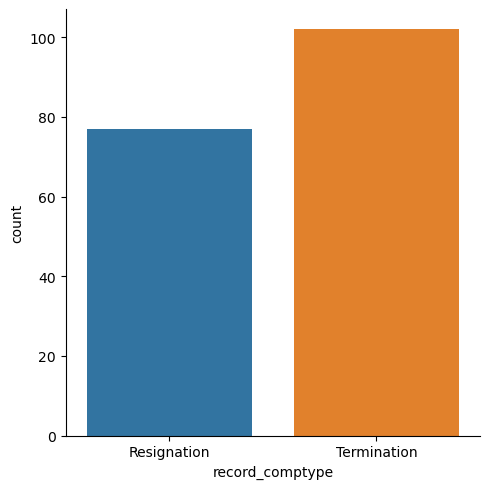

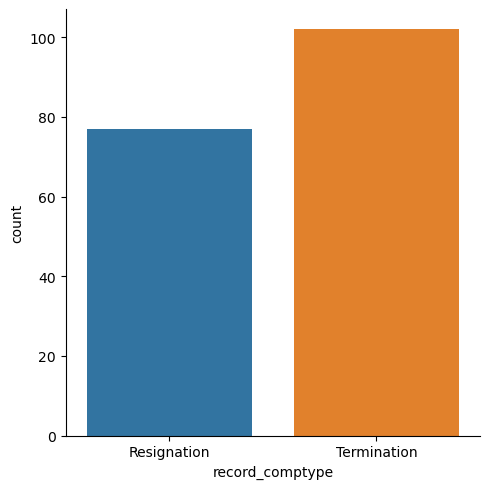

In [52]:
# Visualize the proportion of turnover events
sns.catplot(x='record_comptype', data=turnover_records, kind='count')
plt.show()

What day of the week did a turnover event most likely happen?

In [56]:
get_column_desc('event_weekday_name')

'The English-language name of the day of the week on which the given event fell (e.g., “Monday”).'

In [57]:
turnover_records.head()

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
1056,98000112,Dorothy,Reynolds,61,F,Shift 1,Team 5,Laborer,"[98000106, 98000109, 98000110, 98000111, 98000...",0.526315789,...,4,Friday,Resignation,Poor Teammates,None,Resignation,None,None,NaN,None
1057,98000462,Mark,Bauer,63,M,Shift 3,Team 22,Laborer,"[98000449, 98000450, 98000451, 98000452, 98000...",0.368421053,...,4,Friday,Resignation,Underrecorded Efficacy,None,Resignation,None,None,NaN,None
1058,98000598,Francis,Weber,19,M,Shift 1,Team 5,Laborer,"[98000106, 98000109, 98000110, 98000111, 98000...",0.421052632,...,4,Friday,None,None,None,Termination,Low Efficacy,None,NaN,None
2116,98000264,Mary,Ortiz,61,F,Shift 2,Team 12,Laborer,"[98000246, 98000247, 98000248, 98000249, 98000...",0.789473684,...,0,Monday,Resignation,Recruited Away,None,Resignation,None,None,NaN,None
5272,98000081,Carol,Wieczorek,49,F,Shift 1,Team 3,Laborer,"[98000066, 98000067, 98000068, 98000069, 98000...",0.473684211,...,3,Thursday,None,None,None,Termination,Multiple Sabotages,None,NaN,None


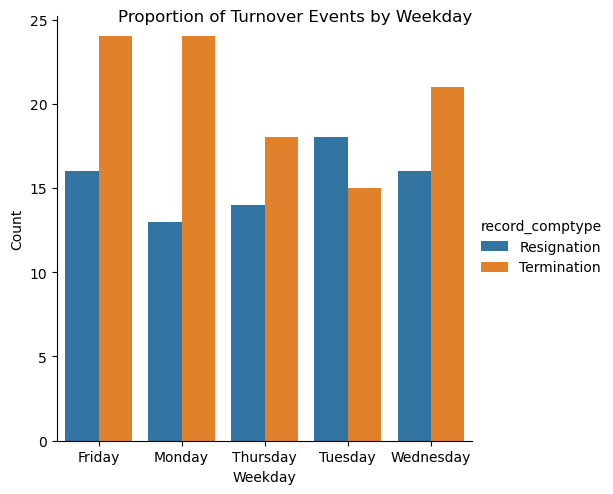

In [64]:
g = sns.catplot(x='event_weekday_name', data=turnover_records, kind='count', hue='record_comptype')
g.fig.suptitle("Proportion of Turnover Events by Weekday")
g.set(xlabel="Weekday", ylabel="Count")
plt.show()

From the plot, it appears that Termination events happened the most on Mondays/Fridays, followed by Thursdays, and a Resignation event happened the most on a Tuesday, followed by Wednesday/Friday

Eventhough both a Resignation and Termination event contribute to turnover, we're only interested in the turnover events that were voluntary, as this contributes to employee attrition. So we will focus on the 'Resignation' subset of turnover events.